<a href="https://colab.research.google.com/github/head1ton/kaggle_dev/blob/master/Data_Science_Bowl_2019_EDA_and_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* event_id : 이벤트 유형에 대해 무작위로 생성된 고유 식별자. 사양표의 event_id열에 매핑
* game_session : 단일 게임 또는 비디오 재생 세션 내에서 무작위로 생성된 고유 식별자 그룹화 이벤트
* timestamp : 클라이언트 생성 날짜 시간
* event_data : 이벤트 매개 변수를 포함하는 반 구조화 된 JSON 형식 문자열. 기본 필드는 event_count, event_code, game_time
* installation_id : 설치된 단일 응용 프로그램 인스턴스 내에서 무작위로 생성 된 고유 식별자 그룹화 게임 세션
* event_count : 게임 세션 내 이벤트 증분 카운터 (1 오프셋) event_data 에서 추출 
* event_code : 이벤트 클래스의 식별자. 게임마다 고유하지만 게임간에 복제될 수 있음. 예를 들어 이벤트 코드 '2000'은 항상 모든 게임에 대한 '게임 시작' 이벤트를 식별. event_data에서 추출.
* game_time : 게임 세션이 시작된 이후의 시간 (밀리 초) event_data에서 추출
* title : 게임 또는 비디오의 제목
* type : 게임 또는 비디오의 미디어 유형. 가능한 값은 'Game', 'Assessment', 'Activity', 'Clip'
* world : 게임 또는 비디오가 속한 응용 프로그램 섹션. 미디어의 교육 커리큘럼 목표를 식별하는 데 도움이 됨. 가능한 값은 'NONE' (앱 시작 화면에서), TREETOPCITY (길이/높이), 'MAGMAPEAK (용량 / 변위), CRYSTALCAVES (무게)

* event_id - 이벤트 유형의 글로벌 고유 식별자.
* info - 이벤트 설명
* args - JSON 형식의 이벤트 인수 문자열. 
    * name - 인자 이름
    * type - 인수의 유형 (string, int, number, object, array)
    * info - 논증에 대한 설명

In [59]:
!pip install catboost

In [0]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pylab as plt
import calendar
import warnings
warnings.filterwarnings('ignore')

import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

from sklearn.model_selection import GroupKFold, train_test_split
from typing import Any
from numba import jit
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from itertools import product
import copy
import time

import random
seed = 1234
random.seed(seed)
np.random.seed(seed)

In [0]:
# train 데이터가 너무 커서 test 데이터로 테스트
imsi = pd.read_csv('./test.csv')

In [0]:
train, test = train_test_split(imsi, test_size=0.1, random_state=0)

In [63]:
train.shape

(1040772, 11)

In [64]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
503814,e7561dd2,9c292c3de9c6c5ac,2019-09-25T15:31:32.855Z,"{""scale_weights"":2,""target_weight"":1,""correct""...",77d5414c,75,4025,70205,Pan Balance,Game,CRYSTALCAVES
8423,9d29771f,9aefef9dd7269673,2019-09-23T19:20:12.844Z,"{""description"":""Alright! This one is the littl...",027e7ce5,39,3021,40082,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
596592,bd612267,f281b60cd4433ef4,2019-09-05T18:32:05.075Z,"{""coordinates"":{""x"":15,""y"":84,""stage_width"":10...",85a36690,22,4070,10621,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
601668,67439901,61ecd0cf660bf844,2019-10-08T22:44:24.255Z,"{""description"":""And it's full! I'll put this o...",869ec6d3,133,3010,259772,Bottle Filler (Activity),Activity,MAGMAPEAK
1080980,895865f3,887138ec79d3eeaf,2019-08-04T02:21:10.747Z,"{""duration"":47196,""misses"":0,""toy_earned"":""bal...",ede81700,209,2030,421495,Bubble Bath,Game,MAGMAPEAK


In [65]:
test.shape

(115642, 11)

In [66]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
727672,2a444e03,fc1c67b9157ce436,2019-09-10T16:42:12.392Z,"{""location"":""TABLE"",""scale_weights"":2,""table_w...",9afdf962,59,4030,58658,Pan Balance,Game,CRYSTALCAVES
505671,e9c52111,9100ccb4742c8acb,2019-10-02T15:18:14.407Z,"{""jar"":[{""color"":""pink"",""amount"":2}],""duration...",77d5414c,308,2030,552742,Bottle Filler (Activity),Activity,MAGMAPEAK
134227,37ee8496,26892073fedf70a6,2019-08-28T23:08:58.036Z,"{""bucket"":1,""buckets"":[0,0,0],""coordinates"":{""...",1dd31d7c,16,4030,11276,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
842453,5f0eb72c,ea37f27b0f9a14f7,2019-10-04T18:48:13.280Z,"{""height"":3,""destination"":""middle"",""stumps"":[2...",b6b80f42,53,4020,40914,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
33273,cf82af56,1341b8aeed65add7,2019-09-01T22:22:57.457Z,"{""coordinates"":{""x"":664,""y"":325,""stage_width"":...",090fe325,317,4070,1337700,Scrub-A-Dub,Game,MAGMAPEAK


In [0]:
train_labels = pd.read_csv('./train_labels.csv')
specs = pd.read_csv('./specs.csv')
sample_submission = pd.read_csv('./sample_submission.csv')

In [68]:
# 교육에 사용할 수 없는 교육 데이터를 유지할 필요가 없으므로 평가를 수행하지 않은 installation_id 를 제거하자.
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
keep_id.shape

(954, 1)

In [69]:
train.shape

(1040772, 11)

In [0]:
# 실제 테스트 데이터에서는 중복이 삭제되어 행수가 달라진다.
train = pd.merge(train, keep_id, on="installation_id", how="inner")

In [71]:
train.shape

(1024078, 11)

In [72]:
keep_id.sample(5)

,installation_id
791415,a9190917
118875,1962067f
487626,75857694
971998,d4201b5c
1017484,e0d8c625


In [73]:
train.type.value_counts()

Game          505507
Activity      412818
Assessment     92277
Clip           13476
Name: type, dtype: int64

In [74]:
train.world.value_counts()

MAGMAPEAK       450307
TREETOPCITY     296546
CRYSTALCAVES    275981
NONE              1244
Name: world, dtype: int64

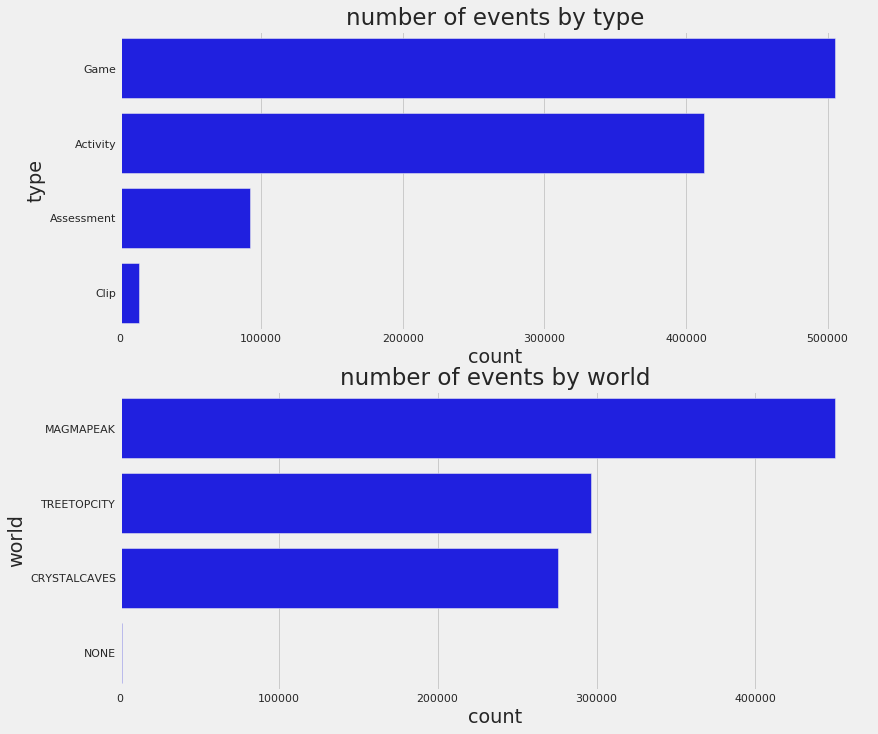

In [75]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(211)
ax1 = sns.countplot(y="type", data=train, color="blue", order=train.type.value_counts().index)
plt.title("number of events by type")

ax2 = fig.add_subplot(212)
ax2 = sns.countplot(y="world", data=train, color="blue", order=train.world.value_counts().index)
plt.title("number of events by world")

plt.tight_layout(pad=0)
plt.show()

In [76]:
train.title.value_counts()

Bottle Filler (Activity)         99222
Scrub-A-Dub                      84543
Chow Time                        81841
Sandcastle Builder (Activity)    72405
Fireworks (Activity)             54189
Bug Measurer (Activity)          53623
Bubble Bath                      48040
Dino Drink                       47922
Dino Dive                        43350
Crystals Rule                    42052
All Star Sorting                 40620
Chicken Balancer (Activity)      39974
Flower Waterer (Activity)        38976
Happy Camel                      35149
Pan Balance                      34726
Watering Hole (Activity)         31088
Air Show                         24320
Egg Dropper (Activity)           23341
Leaf Leader                      22944
Cauldron Filler (Assessment)     21182
Mushroom Sorter (Assessment)     19692
Bird Measurer (Assessment)       18048
Cart Balancer (Assessment)       17258
Chest Sorter (Assessment)        16097
Crystal Caves - Level 2           1286
Magma Peak - Level 2     

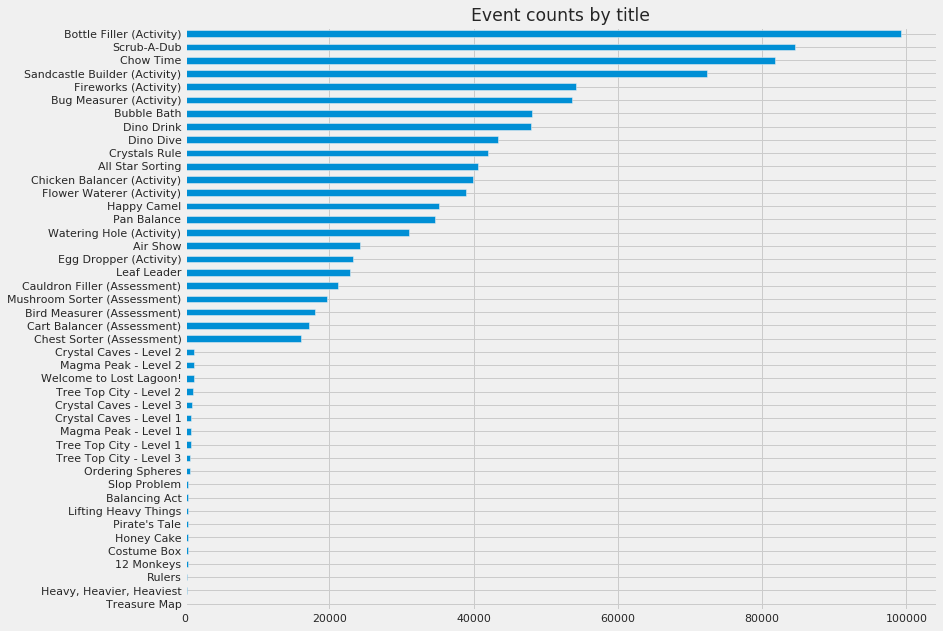

In [77]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(12, 10))
se = train.title.value_counts().sort_values(ascending=True)
se.plot.barh()
plt.title('Event counts by title')
plt.xticks(rotation=0)
plt.show()

In [78]:
train.sample(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
23351,d185d3ea,941e66b4cc44e19c,2019-09-13T18:04:39.266Z,"{""weight"":3,""resources"":[1],""coordinates"":{""x""...",92e5a83a,77,4035,103076,Chow Time,Game,CRYSTALCAVES
128259,c189aaf2,91a82597988701be,2019-09-11T15:35:07.996Z,"{""movie_id"":""Intro"",""duration"":14933333,""descr...",ad0f90e1,7,2083,23637,Happy Camel,Game,CRYSTALCAVES
807145,565a3990,7c0197925746aaf3,2019-10-05T13:22:15.677Z,"{""coordinates"":{""x"":763,""y"":466,""stage_width"":...",c92e8b4c,110,4070,60646,Bug Measurer (Activity),Activity,TREETOPCITY
404029,0a08139c,905e1b6e5f628b0f,2019-08-09T10:21:24.453Z,"{""description"":""One!"",""identifier"":""sid_1"",""me...",eb7b5d02,16,3010,26137,Bug Measurer (Activity),Activity,TREETOPCITY
946285,b2dba42b,1541b85412beef4b,2019-08-27T13:52:19.540Z,"{""description"":""Drag your mold to the sand to ...",f452eef7,17,3010,15140,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [0]:
# 타임스탬프를 기반으로 몇 가지 새로운 열을 추가하고 시각화해보자
def get_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    return df

train = get_time(train)

In [80]:
train.sample(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
457928,84b0e0c8,32ed3bfbcc6f8960,2019-07-27 16:54:02.642000+00:00,"{""description"":""Wow! Pig sure is heavy. Those ...",bf6e55c3,31,3110,29471,Chicken Balancer (Activity),Activity,CRYSTALCAVES,2019-07-27,7,16,5
746766,02a42007,24f0596109859812,2019-10-13 20:02:46.128000+00:00,"{""rocket"":3,""coordinates"":{""x"":330,""y"":653,""st...",fdfed7eb,55,4030,39517,Fireworks (Activity),Activity,TREETOPCITY,2019-10-13,10,20,6
147599,4a4c3d21,a1764905dfa53ffe,2019-08-26 21:32:09.852000+00:00,"{""height"":4,""bird_height"":8,""correct"":false,""c...",c285f89d,8,4025,8206,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-26,8,21,0
106206,3d8c61b0,ef04dbfc1adbe56b,2019-09-15 18:05:10.025000+00:00,"{""source"":""scale"",""has_toy"":false,""bowl_id"":3,...",30fdddc8,33,4030,55837,Happy Camel,Game,CRYSTALCAVES,2019-09-15,9,18,6
883389,bb3e370b,b4d8ac0779bb89ce,2019-08-26 14:00:22.638000+00:00,"{""bottle"":{""amount"":2,""color"":""blue""},""bottles...",776e321e,47,4030,71699,Bottle Filler (Activity),Activity,MAGMAPEAK,2019-08-26,8,14,0


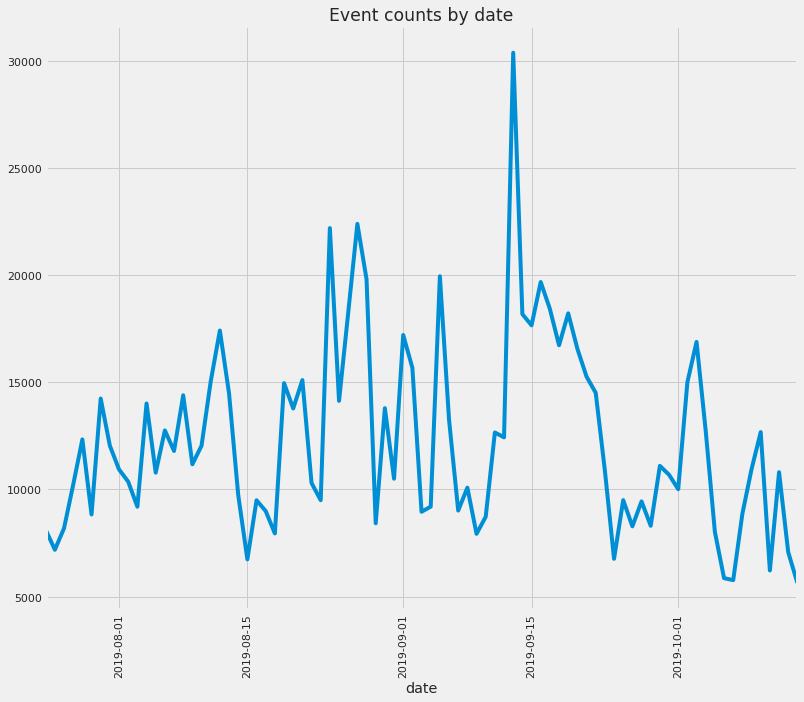

In [81]:
fig = plt.figure(figsize=(12, 10))
se = train.groupby('date')['date'].count()
se.plot()
plt.title('Event counts by date')
plt.xticks(rotation=90)
plt.show()

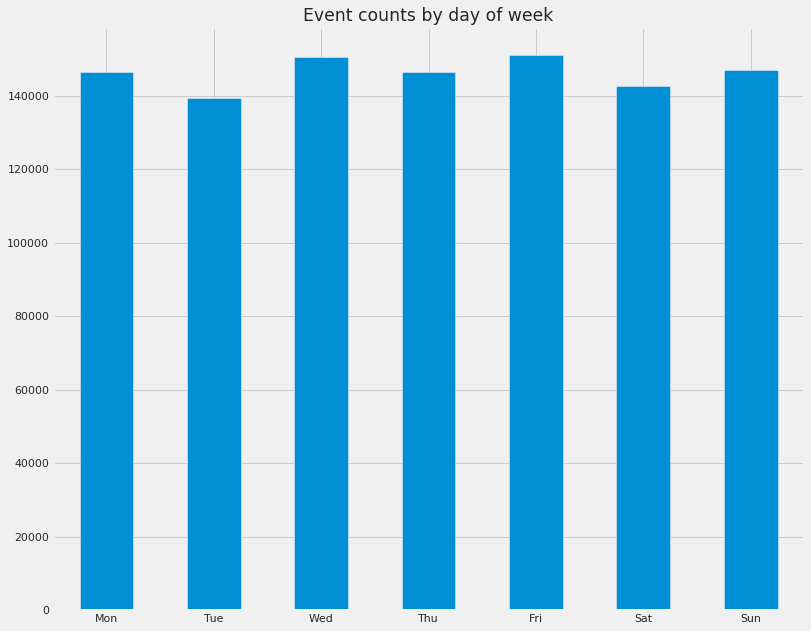

In [82]:
fig = plt.figure(figsize=(12, 10))
se = train.groupby('dayofweek')['dayofweek'].count()
se.index = list(calendar.day_abbr)
se.plot.bar()
plt.title('Event counts by day of week')
plt.xticks(rotation=0)
plt.show()

In [83]:
train.dayofweek.value_counts()

4    151154
2    150700
6    147003
0    146542
3    146454
5    142780
1    139445
Name: dayofweek, dtype: int64

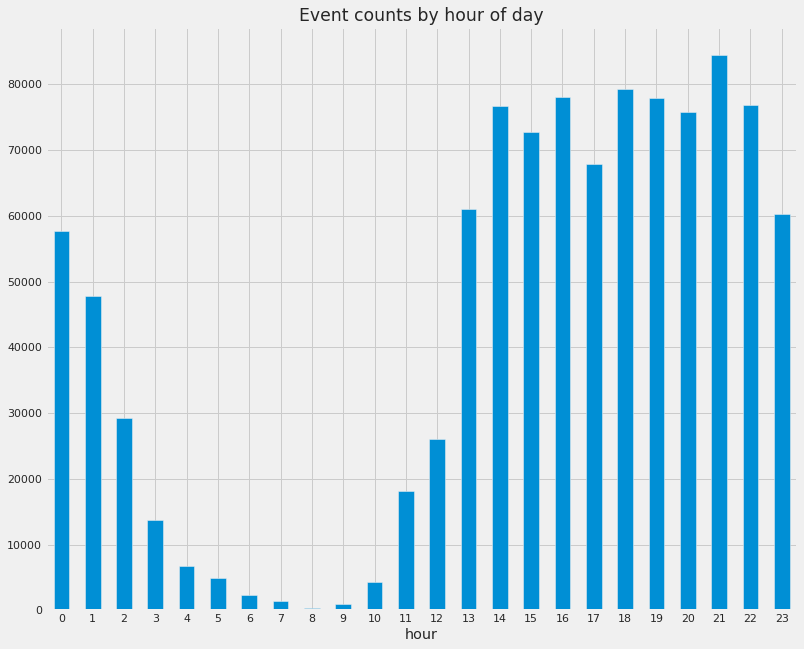

In [84]:
# 시간별 분포를 확인.
fig = plt.figure(figsize=(12, 10))
se = train.groupby('hour')['hour'].count()
se.plot.bar()
plt.title('Event counts by hour of day')
plt.xticks(rotation=0)
plt.show()

In [85]:
# 시간별 분포를 보면 이상한 점이 보인다. 애들이 밤늦게까지 하고.. 아침엔 분포 수가 내려간다. 이건 므지?
# 왜 인지 나중에 확인해보고..
test.sample(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
700417,46cd75b4,4f96ccee339dd015,2019-08-15T11:58:31.525Z,"{""side"":""left"",""layout"":{""left"":{""chickens"":1,...",95b591c1,21,4022,29553,Chicken Balancer (Activity),Activity,CRYSTALCAVES
1099595,1c178d24,ed785edc7d159dbc,2019-08-27T13:45:38.365Z,"{""duration"":7585,""misses"":0,""round"":3,""event_c...",f452eef7,66,2030,74593,Pan Balance,Game,CRYSTALCAVES
1136012,4ef8cdd3,3e1f515d4d9e7ddc,2019-08-25T21:50:23.522Z,"{""weight"":1,""correct"":true,""scale_weight"":4,""s...",fc0367c0,50,4020,91799,Chow Time,Game,CRYSTALCAVES
584745,46cd75b4,7f095eb84fee89a7,2019-10-03T12:52:12.086Z,"{""side"":""left"",""layout"":{""left"":{""chickens"":4,...",8446fe1a,68,4022,71952,Chicken Balancer (Activity),Activity,CRYSTALCAVES
647411,2dc29e21,e495fbad69a8bca9,2019-09-16T22:09:55.765Z,"{""dinosaur"":""sonny"",""house"":{""size"":5,""positio...",8cd5bc7c,45,4020,54578,All Star Sorting,Game,TREETOPCITY


In [86]:
test.shape

(115642, 11)

In [87]:
test.installation_id.nunique() # nunique 는 몇 개인지 나타내준다

957

In [88]:
sample_submission.shape[0]

1000

In [0]:
# 훈련데이터와 테스트데이터에서 겹치는 부분이 있는지 확인. 실제 train 데이터를 쓰면 없을기다.
# set(list(train.installation_id.unique())).intersection(set(list(test.installation_id.unique())))

In [90]:
test['timestamp'] = pd.to_datetime(test['timestamp'])
print(f'The date range in train is: {train.timestamp.dt.date.min()} to {train.timestamp.dt.date.max()}')
print(f'The date range in test is: {test.timestamp.dt.date.min()} to {test.timestamp.dt.date.max()}')

The date range in train is: 2019-07-24 to 2019-10-14
The date range in test is: 2019-07-24 to 2019-10-14


In [91]:
train_labels.sample(5)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
14432,c32dfe9792d549c3,cde4f09d,Chest Sorter (Assessment),0,1,0.0,0
11646,f9d643fb1ce94eeb,a1d55511,Mushroom Sorter (Assessment),1,0,1.0,3
792,e2f04b9531d6a5b3,08987c08,Cart Balancer (Assessment),0,2,0.0,0
2941,d7c299028d21a535,26ef4a4a,Cart Balancer (Assessment),1,0,1.0,3
11127,a170529dd0d139b9,9bc0aa21,Cart Balancer (Assessment),1,0,1.0,3


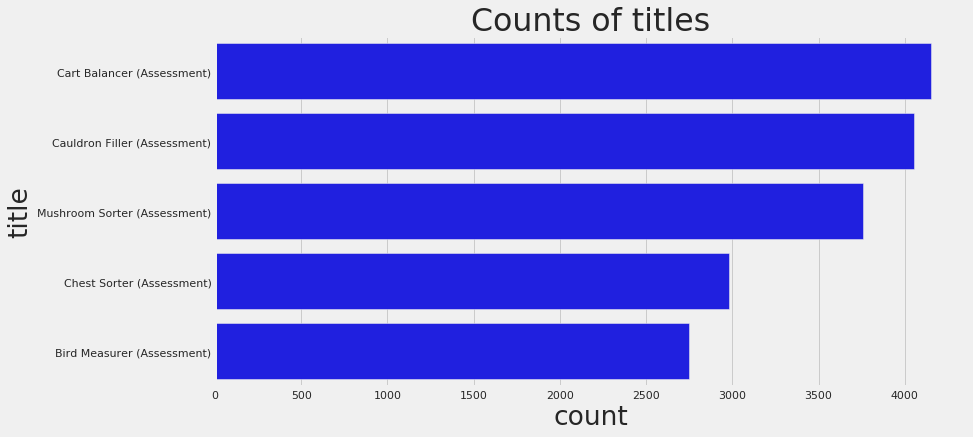

In [92]:
plt.rcParams.update({'font.size':22})

plt.figure(figsize=(12, 6))
sns.countplot(y="title", data=train_labels, color='blue', order=train_labels.title.value_counts().index)
plt.title('Counts of titles')
plt.show()

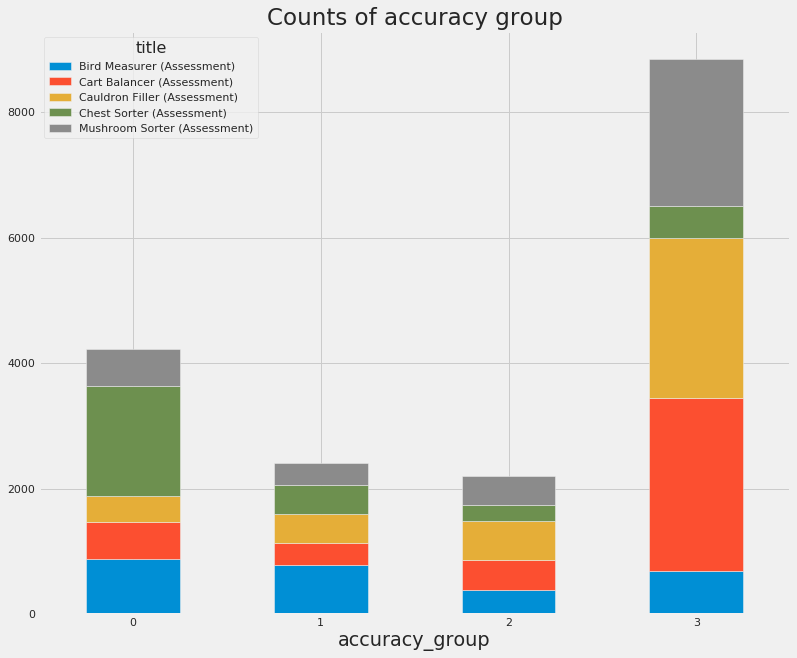

In [93]:
# accuracy_group 
# 3 : 첫 번째 시도에서 평가 해결
# 2 : 두 번째 시도에서 평가 해결
# 1 : 3회 이상의 시도 후 평가 해결
# 0: 미 평가

plt.rcParams.update({'font.size': 16})

se = train_labels.groupby(['title', 'accuracy_group'])['accuracy_group'].count().unstack('title')
se.plot.bar(stacked=True, rot=0, figsize=(12, 10))
plt.title("Counts of accuracy group")
plt.show()

In [94]:
# 위에 보면 가슴분류기가 평가가 많이 되지 않은 것으로 보인다.

train_labels[train_labels.installation_id == "0006a69f"]

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [95]:
train[(train.event_code == 4100) & (train.installation_id == "0006a69f") & (train.title == "Bird Measurer (Assessment)")]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek


In [97]:
train[
      (train.installation_id == "0006a69f") & 
      (
          ((train.type == "Assessment") 
          & (train.title == 'Bird Measurer (Assessment)') 
          & (train.event_code == 4110)) 
          | ((train.type == "Assessment") 
          & (train.title != 'Bird Measurer (Assessment)') 
          & (train.event_code == 4100))
        )
      ]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek


In [98]:
train[~train.installation_id.isin(train_labels.installation_id.unique())].installation_id.nunique()

954

In [100]:
train_labels.installation_id.unique()

array(['0006a69f', '0006c192', '00129856', ..., 'ffc90c32', 'ffd2871d',
       'ffeb0b1b'], dtype=object)

In [101]:
train.installation_id.isin(train_labels.installation_id.unique())

Series([], Name: installation_id, dtype: bool)

In [99]:
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(0, 15)

In [102]:
# Feature Engineering

print(f'Number of rows in train_labels: {train_labels.shape[0]}')
print(f'Number of unique game_sessions in train_labels: {train_labels.game_session.nunique()}')

Number of rows in train_labels: 17690
Number of unique game_sessions in train_labels: 17690


In [0]:
train = train.drop(['date', 'month', 'hour', 'dayofweek'], axis=1)

In [106]:
train.sample(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
229693,f50fc6c1,d490992578e3e501,2019-09-14T00:27:12.948Z,"{""cloud"":""right"",""cloud_size"":2,""event_count"":...",3267eb2c,73,4021,176524,Watering Hole (Activity),Activity,MAGMAPEAK
644687,923afab1,76288d78ed67f259,2019-09-15T22:05:04.638Z,"{""description"":""Put the right sized bucket und...",8cd5bc7c,2,3010,378,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1123030,8b757ab8,abebf40e8260fd88,2019-08-25T12:38:06.621Z,"{""description"":""You need more."",""identifier"":""...",f86a6ed4,201,3120,174440,Crystals Rule,Game,TREETOPCITY
712013,27253bdc,84f8e68b9cd969cd,2019-08-06T14:46:22.463Z,"{""event_code"": 2000, ""event_count"": 1}",97f14e50,1,2000,0,Tree Top City - Level 1,Clip,TREETOPCITY
53960,69fdac0a,8a9ea9be7a5e5844,2019-08-31T17:13:32.157Z,"{""description"":""Now we have three bowls. Epide...",0b607c82,34,3110,107758,Happy Camel,Game,CRYSTALCAVES


In [107]:
test111 = list(map(lambda x, y: str(x) + '_' + str(y), train['title'][:5], train['event_code'][:5]))
test111

['Pan Balance_4025',
 'Mushroom Sorter (Assessment)_3021',
 'Chest Sorter (Assessment)_4070',
 'Bottle Filler (Activity)_3010',
 'Bubble Bath_2030']

In [108]:
list_of_user_activities111 = list(set(train['title'].unique()).union(set(test['title'].unique())))
list_of_user_activities111

['Chicken Balancer (Activity)',
 'Crystal Caves - Level 2',
 'Bug Measurer (Activity)',
 'Crystal Caves - Level 3',
 'Magma Peak - Level 2',
 'Cauldron Filler (Assessment)',
 'Flower Waterer (Activity)',
 'Rulers',
 'Slop Problem',
 'Sandcastle Builder (Activity)',
 'Crystal Caves - Level 1',
 'Leaf Leader',
 'Happy Camel',
 'Tree Top City - Level 3',
 'Treasure Map',
 'Costume Box',
 'Tree Top City - Level 1',
 'Scrub-A-Dub',
 'Ordering Spheres',
 'Watering Hole (Activity)',
 'Lifting Heavy Things',
 'Bubble Bath',
 'Mushroom Sorter (Assessment)',
 'Balancing Act',
 'Bottle Filler (Activity)',
 'Chow Time',
 'Egg Dropper (Activity)',
 'Heavy, Heavier, Heaviest',
 'Air Show',
 'Magma Peak - Level 1',
 'Pan Balance',
 'Dino Drink',
 '12 Monkeys',
 'Honey Cake',
 'Cart Balancer (Assessment)',
 'Fireworks (Activity)',
 'All Star Sorting',
 'Crystals Rule',
 'Dino Dive',
 "Pirate's Tale",
 'Welcome to Lost Lagoon!',
 'Chest Sorter (Assessment)',
 'Tree Top City - Level 2',
 'Bird Measurer 

In [109]:
activities_map111 = dict(zip(list_of_user_activities111, np.arange(len(list_of_user_activities111))))
activities_map111

{'12 Monkeys': 32,
 'Air Show': 28,
 'All Star Sorting': 36,
 'Balancing Act': 23,
 'Bird Measurer (Assessment)': 43,
 'Bottle Filler (Activity)': 24,
 'Bubble Bath': 21,
 'Bug Measurer (Activity)': 2,
 'Cart Balancer (Assessment)': 34,
 'Cauldron Filler (Assessment)': 5,
 'Chest Sorter (Assessment)': 41,
 'Chicken Balancer (Activity)': 0,
 'Chow Time': 25,
 'Costume Box': 15,
 'Crystal Caves - Level 1': 10,
 'Crystal Caves - Level 2': 1,
 'Crystal Caves - Level 3': 3,
 'Crystals Rule': 37,
 'Dino Dive': 38,
 'Dino Drink': 31,
 'Egg Dropper (Activity)': 26,
 'Fireworks (Activity)': 35,
 'Flower Waterer (Activity)': 6,
 'Happy Camel': 12,
 'Heavy, Heavier, Heaviest': 27,
 'Honey Cake': 33,
 'Leaf Leader': 11,
 'Lifting Heavy Things': 20,
 'Magma Peak - Level 1': 29,
 'Magma Peak - Level 2': 4,
 'Mushroom Sorter (Assessment)': 22,
 'Ordering Spheres': 18,
 'Pan Balance': 30,
 "Pirate's Tale": 39,
 'Rulers': 7,
 'Sandcastle Builder (Activity)': 9,
 'Scrub-A-Dub': 17,
 'Slop Problem': 8,
 

In [113]:
train['title111'] = train['title'].map(activities_map111)
train.sample(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,title111
488824,df4940d3,e7a6a11aad79c461,2019-07-28T18:52:30.976Z,"{""description"":""Wow! That looks so cool!"",""ide...",763b2ac3,60,3110,103497,Bottle Filler (Activity),Activity,MAGMAPEAK,24
476981,88d4a5be,afe73a3dbadecfe2,2019-08-18T00:08:51.993Z,"{""description"":""Drag the mushrooms to the tree...",71e82b16,32,3120,29052,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,22
181978,8d7e386c,9d295acccaed28da,2019-09-29T17:06:46.418Z,"{""description"":""Which one of these bowls has E...",2a47e474,32,3010,58554,Happy Camel,Game,CRYSTALCAVES,12
1002502,0a08139c,dc0ada12fec5f7aa,2019-08-26T13:35:57.953Z,"{""description"":""Three!"",""identifier"":""sid_3"",""...",dd9a2277,145,3010,130872,Bug Measurer (Activity),Activity,TREETOPCITY,2
886962,7372e1a5,0afa5f2bad2c3d65,2019-08-08T20:54:46.145Z,"{""coordinates"":{""x"":297,""y"":688,""stage_width"":...",c285f89d,70,4070,65046,Chow Time,Game,CRYSTALCAVES,25


In [0]:
train.drop('title111', axis=1, inplace=True)

In [0]:
def encode_title(train, test, train_labels):
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train['title_event_code'].unique()).union(test['title_event_code'].unique()))
    
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))

    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))

    assess_titles = list(set(train[train['type'] == "Assessment"]['title'].value_counts().index).union(
        set(test[test['type'] == "Assessment"]['title'].value_counts().index)))
    
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110

    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])

    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code


train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)

categoricals = ['session_title']

In [120]:
train.sample(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,title_event_code
371306,71fe8f75,42be4c75fca0e7e4,2019-10-12 02:24:30.591000+00:00,"{""description"":""Two!"",""identifier"":""sid_2"",""me...",56a739ec,52,3110,57967,2,Activity,2,Bug Measurer (Activity)_3110
507044,71fe8f75,1032b30ee005aad7,2019-10-02 18:09:18.746000+00:00,"{""description"":""One!"",""identifier"":""sid_1"",""me...",77d5414c,90,3110,61205,2,Activity,2,Bug Measurer (Activity)_3110
1052382,b80e5e84,de4eac8d941c0e0d,2019-09-19 22:05:35.690000+00:00,"{""description"":""Incoming!"",""identifier"":""Buddy...",e6ea5608,64,3110,102577,26,Activity,3,Egg Dropper (Activity)_3110
937730,f3cd5473,549a87f243c3e68f,2019-09-16 14:14:29.711000+00:00,"{""coordinates"":{""x"":354,""y"":334,""stage_width"":...",cf22f7b2,502,4070,821292,30,Game,3,Pan Balance_4070
797779,5d042115,f3c042a9dfda7503,2019-10-04 19:49:14.006000+00:00,"{""flowers"":[0,0,0,1,3],""flower"":0,""coordinates...",ac564de9,106,4030,198922,6,Activity,2,Flower Waterer (Activity)_4030


In [121]:
activities_labels

{0: 'Chicken Balancer (Activity)',
 1: 'Crystal Caves - Level 2',
 2: 'Bug Measurer (Activity)',
 3: 'Crystal Caves - Level 3',
 4: 'Magma Peak - Level 2',
 5: 'Cauldron Filler (Assessment)',
 6: 'Flower Waterer (Activity)',
 7: 'Rulers',
 8: 'Slop Problem',
 9: 'Sandcastle Builder (Activity)',
 10: 'Crystal Caves - Level 1',
 11: 'Leaf Leader',
 12: 'Happy Camel',
 13: 'Tree Top City - Level 3',
 14: 'Treasure Map',
 15: 'Costume Box',
 16: 'Tree Top City - Level 1',
 17: 'Scrub-A-Dub',
 18: 'Ordering Spheres',
 19: 'Watering Hole (Activity)',
 20: 'Lifting Heavy Things',
 21: 'Bubble Bath',
 22: 'Mushroom Sorter (Assessment)',
 23: 'Balancing Act',
 24: 'Bottle Filler (Activity)',
 25: 'Chow Time',
 26: 'Egg Dropper (Activity)',
 27: 'Heavy, Heavier, Heaviest',
 28: 'Air Show',
 29: 'Magma Peak - Level 1',
 30: 'Pan Balance',
 31: 'Dino Drink',
 32: '12 Monkeys',
 33: 'Honey Cake',
 34: 'Cart Balancer (Assessment)',
 35: 'Fireworks (Activity)',
 36: 'All Star Sorting',
 37: 'Crystals

In [122]:
win_code

{0: 4100,
 1: 4100,
 2: 4100,
 3: 4100,
 4: 4100,
 5: 4100,
 6: 4100,
 7: 4100,
 8: 4100,
 9: 4100,
 10: 4100,
 11: 4100,
 12: 4100,
 13: 4100,
 14: 4100,
 15: 4100,
 16: 4100,
 17: 4100,
 18: 4100,
 19: 4100,
 20: 4100,
 21: 4100,
 22: 4100,
 23: 4100,
 24: 4100,
 25: 4100,
 26: 4100,
 27: 4100,
 28: 4100,
 29: 4100,
 30: 4100,
 31: 4100,
 32: 4100,
 33: 4100,
 34: 4100,
 35: 4100,
 36: 4100,
 37: 4100,
 38: 4100,
 39: 4100,
 40: 4100,
 41: 4100,
 42: 4100,
 43: 4110}

In [0]:
def get_data(user_sample, test_set=False):
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity':0, 'Assessment':0, 'Game':0}
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities}
    event_code_count = {eve: 0 for eve in list_of_event_code}
    last_session_time_sec = 0

    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []

    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]

        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent
        
        if (session_type == 'Assessment') & (test_set or len(session) > 1):
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()

            features = user_activities_count.copy()
            features.update(time_spent_each_act.copy())
            features.update(event_code_count.copy())

            features['installation_id'] = session['installation_id'].iloc[-1]
            features['session_title'] = session['title'].iloc[0]
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts

            accumulated_correct_attempts += true_attempts
            accumulated_uncorrect_attempts += false_attempts

            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)

            features['accumulated_accuracy'] = accumulated_accuracy / counter if counter > 0 else 0

            accuracy = true_attempts / (true_attempts + false_attempts) if (true_attempts + false_attempts) != 0 else 0
            accumulated_accuracy += accuracy

            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1

            features['accumulated_accuracy_group'] = accumulated_accuracy_group / counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            features['accumulated_actions'] = accumulated_actions

            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
            
            counter += 1
        
        n_of_event_codes = Counter(session['event_code'])

        for key in n_of_event_codes.keys():
            event_code_count[key] += n_of_event_codes[key]
        
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activity = session_type
    
    if test_set:
        return all_assessments[-1]
    
    return all_assessments

In [124]:
train[train.installation_id == "0006a69f"]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,title_event_code


In [127]:
# train[train.installation_id == "c42aeee6"]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,title_event_code
895515,71fe8f75,f10976498227b454,2019-09-01 18:10:36.418000+00:00,"{""description"":""Five!"",""identifier"":""sid_5"",""m...",c42aeee6,28,3110,31667,2,Activity,2,Bug Measurer (Activity)_3110
895670,e37a2b78,862ca503edf6afd5,2019-09-01 18:13:47.546000+00:00,"{""description"":""Whoops. This caterpillar is to...",c42aeee6,51,3120,57799,43,Assessment,2,Bird Measurer (Assessment)_3120
895575,71fe8f75,f10976498227b454,2019-09-01 18:11:47.594000+00:00,"{""description"":""Let's put this bug back where ...",c42aeee6,88,3110,102776,2,Activity,2,Bug Measurer (Activity)_3110
894986,9d29771f,a517304e44807d1f,2019-08-18 17:46:31.572000+00:00,"{""description"":""That's one!"",""identifier"":""Dot...",c42aeee6,6,3021,2618,22,Assessment,2,Mushroom Sorter (Assessment)_3021
895838,f56e0afc,6a21cf4d19b3a85b,2019-09-01 18:18:15.608000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",c42aeee6,1,2000,0,43,Assessment,2,Bird Measurer (Assessment)_2000
...,...,...,...,...,...,...,...,...,...,...,...,...
895201,51102b85,6829eadda4831114,2019-08-20 22:12:48.278000+00:00,"{""hat"":0,""caterpillar"":""left"",""coordinates"":{""...",c42aeee6,61,4030,55999,43,Assessment,2,Bird Measurer (Assessment)_4030
895240,5c2f29ca,e91fc2e36b5e5241,2019-09-01 18:00:06.750000+00:00,"{""crystal_id"":""gem08"",""weight"":6,""coordinates""...",c42aeee6,5,4020,3842,34,Assessment,3,Cart Balancer (Assessment)_4020
895828,587b5989,39115c6f4be49f19,2019-09-01 18:17:02.319000+00:00,"{""coordinates"":{""x"":598,""y"":442,""stage_width"":...",c42aeee6,127,4070,139495,36,Game,2,All Star Sorting_4070
895202,4a4c3d21,6829eadda4831114,2019-08-20 22:12:48.489000+00:00,"{""height"":1,""bird_height"":4,""correct"":false,""c...",c42aeee6,62,4025,56231,43,Assessment,2,Bird Measurer (Assessment)_4025


In [125]:
sample_id = train[train.installation_id == "0006a69f"]
sample_id_data = get_data(sample_id)
sample_df = pd.DataFrame(sample_id_data)
sample_df.iloc[:, -10:]

IndexError: ignored

In [128]:
train_labels[train_labels.installation_id == "0006a69f"].iloc[:, [0, 1, -3, -1]]

,game_session,installation_id,num_incorrect,accuracy_group
0,6bdf9623adc94d89,0006a69f,0,3
1,77b8ee947eb84b4e,0006a69f,11,0
2,901acc108f55a5a1,0006a69f,0,3
3,9501794defd84e4d,0006a69f,1,2
4,a9ef3ecb3d1acc6a,0006a69f,0,3


In [131]:
compiled_data = []
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=train.installation_id.nunique(), desc='Installation_id', position=0):
    compiled_data += get_data(user_sample)

In [132]:
reduce_train = pd.DataFrame(compiled_data)
del compiled_data
reduce_train.shape

(1919, 103)

In [133]:
reduce_train.sample(5)

,Clip,Activity,Assessment,Game,Chicken Balancer (Activity),Crystal Caves - Level 2,Bug Measurer (Activity),Crystal Caves - Level 3,Magma Peak - Level 2,Cauldron Filler (Assessment),Flower Waterer (Activity),Rulers,Slop Problem,Sandcastle Builder (Activity),Crystal Caves - Level 1,Leaf Leader,Happy Camel,Tree Top City - Level 3,Treasure Map,Costume Box,Tree Top City - Level 1,Scrub-A-Dub,Ordering Spheres,Watering Hole (Activity),Lifting Heavy Things,Bubble Bath,Mushroom Sorter (Assessment),Balancing Act,Bottle Filler (Activity),Chow Time,Egg Dropper (Activity),"Heavy, Heavier, Heaviest",Air Show,Magma Peak - Level 1,Pan Balance,Dino Drink,12 Monkeys,Honey Cake,Cart Balancer (Assessment),Fireworks (Activity),All Star Sorting,Crystals Rule,Dino Dive,Pirate's Tale,Welcome to Lost Lagoon!,Chest Sorter (Assessment),Tree Top City - Level 2,Bird Measurer (Assessment),2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,installation_id,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
1131,1,2,1,3,0,0,0,0,0,0,0,0,0,42,0,0,46,0,0,0,0,101,0,0,0,0,0,0,19,44,89,0,0,0,0,60,0,0,0,0,0,57,0,0,0,0,0,0,2,1,0,0,0,1,0,0,0,1,4,3,3,128,6,21,32,91,13,0,21,106,11,131,21,7,22,30,1,9,0,1,39,304,1,34,0,1,6,0,0,1,480bfe4f,34,1,0,5.0,1.00,1,0,0,0,1,3.0,1052
567,1,18,9,15,365,0,212,0,0,0,181,0,0,101,0,378,178,0,0,0,0,244,0,595,0,2231,0,0,579,349,317,0,244,0,1043,675,0,0,0,278,280,28,104,0,0,0,0,0,8,102,191,36,194,12,6,41,4,7,12,5,8,931,36,208,195,1063,137,28,295,1273,74,923,264,73,206,202,11,64,0,8,224,1340,12,200,0,9,8,2,39,8,8cd5bc7c,34,7,7,25927.7,0.60,3,3,0,2,5,1.9,8459
1011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,f69fc509,22,0,0,0.0,0.00,3,0,0,0,0,0.0,0
986,2,3,2,5,74,0,0,0,0,0,0,0,0,18,0,231,0,0,0,0,0,159,0,7,0,0,0,0,0,249,0,0,0,0,132,0,0,0,0,0,65,0,67,0,0,0,0,0,8,15,0,4,0,2,2,2,1,1,6,0,7,91,7,54,40,156,8,2,32,143,0,88,31,4,56,41,0,12,0,1,53,175,1,53,0,0,9,3,0,2,7eff5909,22,1,3,43187.5,0.25,3,1,0,1,0,1.0,1110
1594,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,17,2,21,12,29,0,0,11,50,0,18,9,0,24,12,0,2,0,0,12,41,0,9,0,0,0,0,0,1,9afdf962,5,0,0,0.0,0.00,3,0,0,0,0,0.0,279


In [135]:
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=test.installation_id.nunique(), desc='Installation_id', position=0):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)
    
reduce_test = pd.DataFrame(new_test)

IndexError: ignored

In [136]:
reduce_test.shape

NameError: ignored

In [137]:
reduce_test.head()

NameError: ignored

In [0]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')

        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 
                                         2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 
                                         3121, 4020, 4021, 4022, 4025, 4030, 4031, 3010, 
                                         4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 
                                         2020, 4070, 2025, 2030, 4080, 2035, 2040, 4090, 4220, 4095]].sum(axis=1)
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns
    features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]

    return reduce_train, reduce_test, features

reduce_train, reduce_test, features = preprocess(reduce_train, reduce_test)

In [0]:
params = {'n_estimators': 2000,
          'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'subsample': 0.75,
          'subsample_freq': 1,
          'learning_rate': 0.04,
          'feature_fraction': 0.9,
          'max_depth': 15,
          'lambda_l1': 1,
          'lambda_l2': 1,
          'verbose': 100,
          'early_stopping_rounds': 100, 
          'eval_metric': 'cappa'}

In [0]:
y = reduce_train['accuracy_group']

In [0]:
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

In [0]:
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate']

In [0]:
# Quadratic Weighted Cappa function
from sklearn.base import BaseEstimator, TransformerMixin
@jit
def qwk(a1, a2):
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[i] += 1
        o += (i - j) * (i - j)
    
    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)
    
    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    
    return 'cappa', qwk(y_true, y_pred), True

In [0]:
# Model wrappers
class LGBWrapper_regr(object):
    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'
        
        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')
        
        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')
        
        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.coumns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'
        
        self.model.fit(X=X_train, y=y_train, eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric, verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'], categorical_feature=categorical_columns)
        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)


def eval_qwk_xgb(y_pred, y_true):
    # print('y_true', y_true)
    # print('y_pred', y_pred)
    y_true = y_true.get_label()
    y_pred = y_pred.argmax(axis=1)
    return 'cappa', -qwk(y_true, y_pred)


class LGBWrapper(object):
    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_qwk_lgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)


class CatWrapper(object):
    def __init__(self):
        self.model = cat.CatBoostClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**{k: v for k, v in params.items() if k != 'cat_cols'})

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = None
        else:
            categorical_columns = None
        
        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       cat_features=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if 'MultiClass' not in self.model.get_param('loss_function'):
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)


class XGBWrapper(object):
    def __init__(self):
        self.model = xgb.XGBClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_metric=eval_qwk_xgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

        scores = self.model.evals_result()
        self.best_score_ = {k: {m: m_v[-1] for m, m_v in v.items()} for k, v in scores.items()}
        self.best_score_ = {k: {m: n if m != 'cappa' else -n for m, n in v.items()} for k, v in self.best_score_.items()}

        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)

In [0]:
# MainTransformer
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [0]:
# FeatureTransformer
class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [0]:
# RegressorModel class
class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

In [0]:
# CategoricalTransformer class
from category_encoders.ordinal import OrdinalEncoder

class CategoricalTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, cat_cols=None, drop_original: bool = False, encoder=OrdinalEncoder()):

        self.cat_cols = cat_cols
        self.drop_original = drop_original
        self.encoder = encoder
        self.default_encoder = OrdinalEncoder()

    def fit(self, X, y=None):

        if self.cat_cols is None:
            kinds = np.array([dt.kind for dt in X.dtypes])
            is_cat = kinds == 'O'
            self.cat_cols = list(X.columns[is_cat])
        self.encoder.set_params(cols=self.cat_cols)
        self.default_encoder.set_params(cols=self.cat_cols)

        self.encoder.fit(X[self.cat_cols], y)
        self.default_encoder.fit(X[self.cat_cols], y)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        new_cat_names = [f'{col}_encoded' for col in self.cat_cols]
        encoded_data = self.encoder.transform(data[self.cat_cols])
        if encoded_data.shape[1] == len(self.cat_cols):
            data[new_cat_names] = encoded_data
        else:
            pass

        if self.drop_original:
            data = data.drop(self.cat_cols, axis=1)
        else:
            data[self.cat_cols] = self.default_encoder.transform(data[self.cat_cols])

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [0]:
mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X=reduce_train, y=y, folds=folds, params=params, preprocesser=mt, transformers=transformers,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)

In [0]:
# The OptimizedRounder class
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [0]:
%%time
pr1 = regressor_model1.predict(reduce_train)

optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

In [0]:
coefficients

In [0]:
opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk(y, opt_preds)

In [0]:
pr1 = regressor_model1.predict(reduce_test)
pr1[pr1 <= coefficients[0]] = 0
pr1[np.where(np.logical_and(pr1 > coefficients[0], pr1 <= coefficients[1]))] = 1
pr1[np.where(np.logical_and(pr1 > coefficients[1], pr1 <= coefficients[2]))] = 2
pr1[pr1 > coefficients[2]] = 3

In [0]:
sample_submission['accuracy_group'] = pr1.astype(int)
sample_submission.to_csv('submission.csv', index=False)

In [0]:
sample_submission.head()